## Preliminares

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

from qiskit import Aer, QuantumCircuit, transpile
from qiskit.opflow import Z, I
from qiskit.utils import  algorithm_globals
from qiskit.algorithms.optimizers import SPSA

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_qsphere

from IPython.display import clear_output

from sklearn.model_selection import train_test_split,cross_val_score

algorithm_globals.random_seed = 42


from Aux_Data import plot_predicted, plot_area, plot_sampled_features
from QWNN import  quantum_weightless_neuron_ry
from quantum_encoding import angle_encoding
from Aux_QuantumML import get_opflow_qnn,apply_circuit, get_bloch_coordinates, get_statevector



Experimentos com o dataset Iris usando diferentes normalizações e fazendo uma representação na esfera de Bloch

## Base de dados selecionada:

In [2]:
class_a = 0
class_b = 1
# Loading some example data
iris = datasets.load_iris()
X_all = iris.data[:, [1,2]]
Y_all = iris.target
X_vec = [np.array(X_all[Y_all == 0]), np.array(X_all[Y_all == 1]), np.array(X_all[Y_all == 2])]
Y_vec = [np.array(Y_all[Y_all == 0]),np.array(Y_all[Y_all == 1]), np.array(Y_all[Y_all == 2])]
X = np.concatenate((X_vec[class_a], X_vec[class_b]), axis=0)
Y = np.concatenate((Y_vec[class_a], Y_vec[class_b]), axis=0)
# Randomly shuffle data and labels 
rnd = np.random.RandomState(42)
idx = rnd.permutation(len(Y))
X, Y = X[idx], Y[idx]
# Scale to the range (0, +1)
y01 = (Y - min(Y))
y01 = y01 // max(y01)
y = 2 * y01 -1

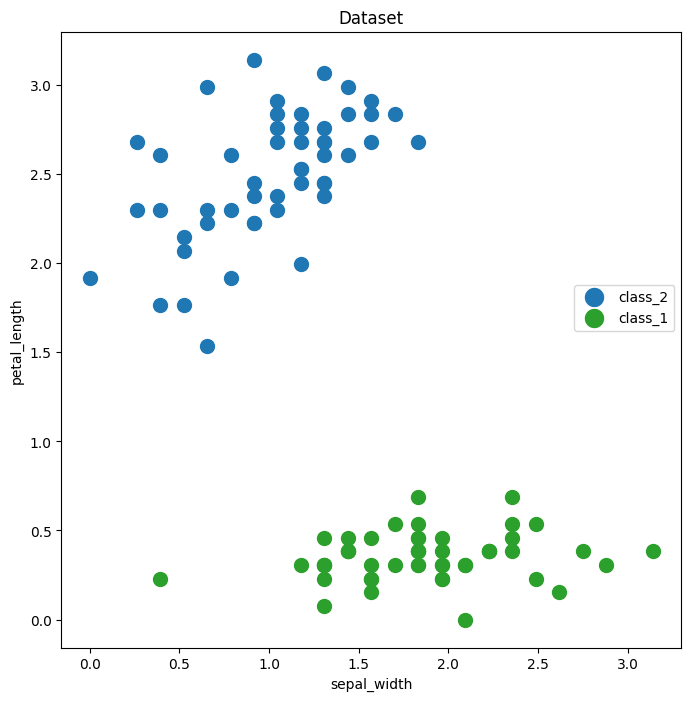

In [10]:
plot_sampled_features(X, y, axis_x_name='sepal_width', axis_y_name='petal_length', class_name_minus="class_1", class_name_plus="class_2")

In [3]:
normalization = np.pi
# Normalize X
minmax_scale = MinMaxScaler((0, normalization)).fit(X)
X = minmax_scale.transform(X)

## Circuito

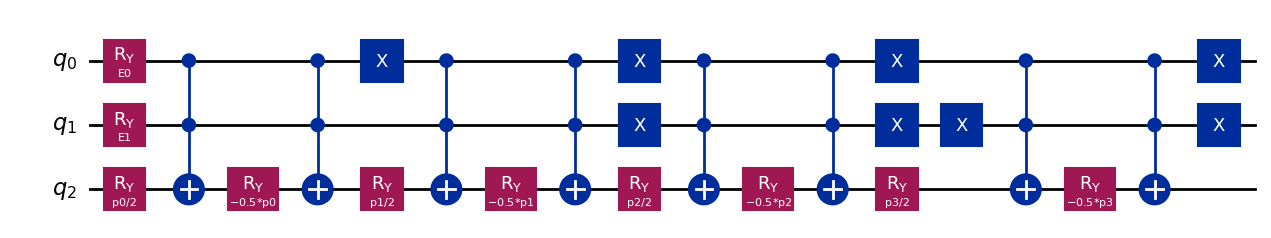

In [7]:
test = QuantumCircuit(3)
feature_map = angle_encoding(2)
test.append(feature_map, [0,1])
ansatz= quantum_weightless_neuron_ry(2)
test.append(ansatz, [0,1,2])
test.decompose().draw('mpl', style='iqx')

In [8]:
# callback function that draws a live plot when the .fit() method is called
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.figsize"] = (6, 4)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


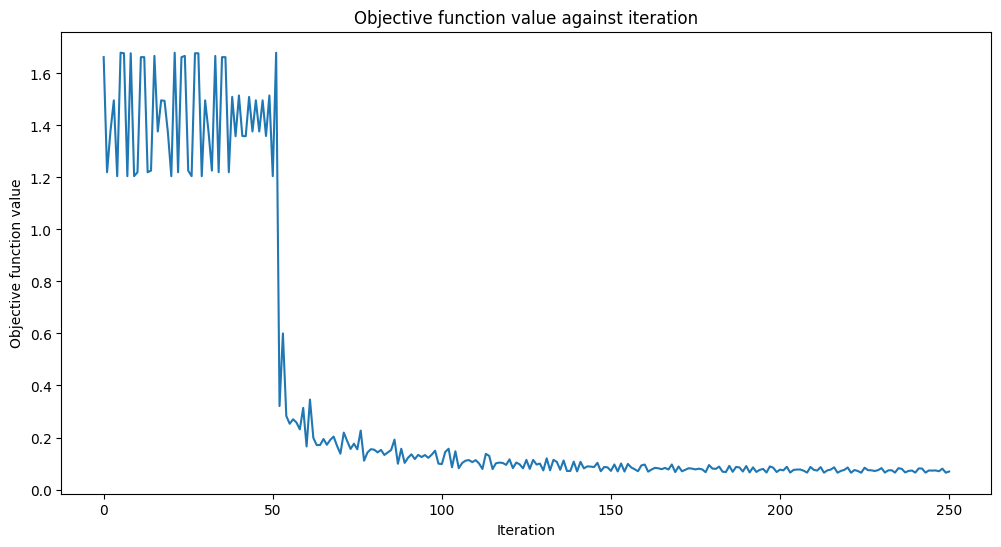

1.0

In [9]:
hamiltonian = Z ^ I ^ I
qnn = get_opflow_qnn(test, feature_map, ansatz, hamiltonian)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer = SPSA(), callback=callback_graph)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X_test, y_test)

## Treinamento

In [11]:

score_list = []
best_score = 0
best_clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
for i in range(30):
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
    qnn = get_opflow_qnn(test, feature_map, ansatz, hamiltonian)
    print("Iteration ", i)
    clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    score_list.append(score)
    if(score>best_score):
        best_score = score
        best_clf = clf
print("Mean: ", np.mean(score_list))
print("Std: ", np.std(score_list))
print(best_score)
print(best_clf._fit_result.x)

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iteration  21
Iteration  22
Iteration  23
Iteration  24
Iteration  25
Iteration  26
Iteration  27
Iteration  28
Iteration  29
Mean:  0.9966666666666666
Std:  0.012472191289246485
1.0
[ 0.11896692 -0.18209971  2.84204502  2.54931751]


In [18]:
print(score_list)

[0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Wrong predicted: 9


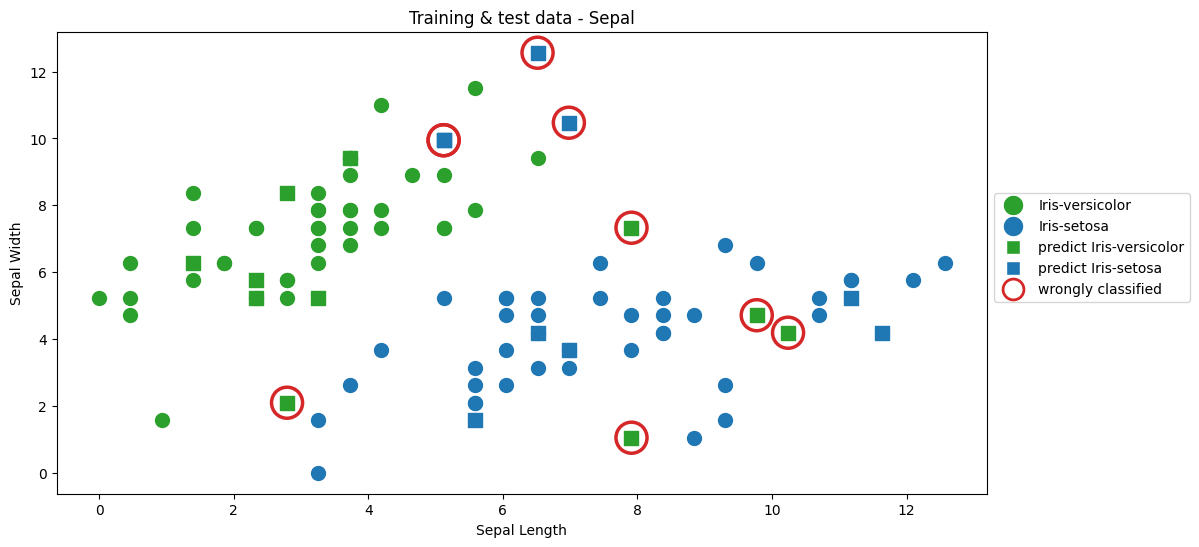

In [38]:
predicted = best_clf.predict(X_test)  
plot_predicted(1,2,X_train, y_train, X_test, y_test, predicted)

In [48]:
best_clf.save("neuron_spsa_4pi.model")

In [ ]:
test2_col1 = np.random.uniform(low=0, high=1.0, size=(1000,))
test2_col2 = np.random.uniform(low=0, high=1.0, size=(1000,))
test2= np.vstack((test2_col2, test2_col1)).T

### Salvando o modelo

In [91]:
opflow_classifier.save("neuron_spsa_2pi.model")

## Plotando os valores previstos

Wrong predicted: 0


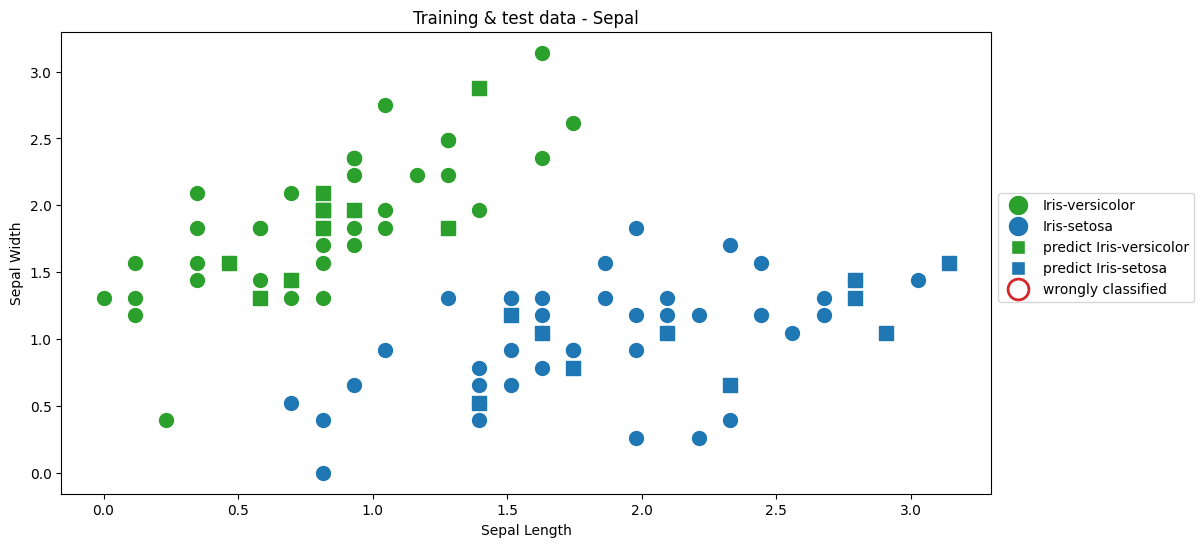

In [21]:
predicted = opflow_classifier.predict(X_test)  
plot_predicted(1,2,X_train, y_train, X_test, y_test, predicted)

Tentando ter ideia das regiões de decisão

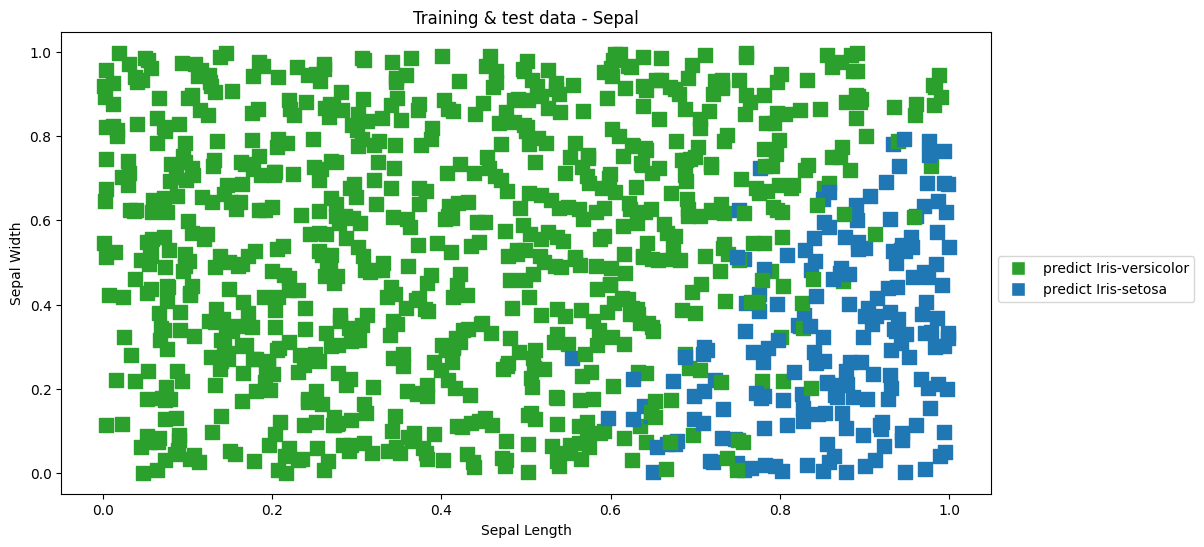

In [22]:
predicted = opflow_classifier.predict(test2)
plot_area(1,2, test2, predicted)

## Carregando modelo

In [22]:
#Para 4pi, utilizar 4pi-0.001
normalization = 4*np.pi-0.001
#normalization = 2*np.pi
# Loading some example data
iris = datasets.load_iris()
X_all = iris.data[:, [0,1]]
Y_all = iris.target
X = np.array(X_all[:100])
Y = np.array(Y_all[:100])

# Randomly shuffle data and labels 
rnd = np.random.RandomState(42)
idx = rnd.permutation(len(Y))
X, Y = X[idx], Y[idx]

# Scale to the range (0, +1)
y01 = (Y - min(Y))
y01 = y01 // max(y01)

# Scale to the range (-1, +1)
minmax_scale = MinMaxScaler((0, normalization)).fit(X)
X = minmax_scale.transform(X)
y = 2 * y01 -1


In [8]:
X

array([[1.97803982, 0.91629786],
       [1.3962634 , 0.39269908],
       [1.86168454, 1.57079633],
       [0.58177642, 1.30899694],
       [0.93084227, 2.35619449],
       [0.93084227, 1.83259571],
       [0.34906585, 2.0943951 ],
       [1.3962634 , 0.52359878],
       [1.27990812, 2.2252948 ],
       [0.93084227, 1.96349541],
       [1.62897397, 2.35619449],
       [0.58177642, 1.43989663],
       [2.0943951 , 1.04719755],
       [1.3962634 , 2.87979327],
       [1.3962634 , 0.78539816],
       [0.81448698, 2.0943951 ],
       [2.90888209, 1.04719755],
       [2.7925268 , 1.30899694],
       [0.58177642, 1.30899694],
       [1.27990812, 1.83259571],
       [1.62897397, 1.04719755],
       [1.51261869, 1.30899694],
       [0.81448698, 1.83259571],
       [0.11635528, 1.57079633],
       [1.51261869, 0.65449847],
       [1.62897397, 3.14159265],
       [0.81448698, 1.96349541],
       [1.62897397, 1.17809725],
       [0.6981317 , 1.43989663],
       [2.32710567, 0.65449847],
       [0.

In [23]:
opflow_classifier = NeuralNetworkClassifier.load("models/neuron_spsa_4pi.model")
qnn = opflow_classifier.neural_network
theta = opflow_classifier._fit_result.x
theta

c:\Users\thiag\anaconda3\envs\qiskit\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.1.3 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array([ 1.42218039, -0.82035216,  2.1121885 ,  1.66328496])

## Plotando na Esfera de Bloch

### Explorando os pontos fixos

Como eles são aplicados no circuito (Porta Ry aplica rotação em theta/2)

In [9]:
print("Sen(theta/2): ", np.sin(theta/2))
print("Cos(theta/2): ",np.cos(theta/2))

Sen(theta/2):  [-0.70274262  0.99915741  0.06153086  0.61095198]
Cos(theta/2):  [0.71144417 0.0410423  0.99810518 0.79166765]


State Vector e Vetor de Bloch

In [10]:
print(get_statevector([0,0], theta))
print(get_statevector([0,np.pi], theta))
print(get_statevector([np.pi,0], theta))
print(get_statevector([np.pi,np.pi], theta))


Statevector([ 0.711-0.j, -0.   -0.j, -0.   -0.j, -0.   +0.j, -0.703+0.j,
             -0.   -0.j, -0.   -0.j, -0.   +0.j],
            dims=(2, 2, 2))
Statevector([ 0.   +0.j,  0.   +0.j,  0.041-0.j, -0.   -0.j,  0.   +0.j,
              0.   +0.j,  0.999-0.j, -0.   -0.j],
            dims=(2, 2, 2))
Statevector([ 0.   +0.j,  0.998-0.j,  0.   +0.j, -0.   -0.j,  0.   +0.j,
              0.062-0.j,  0.   +0.j, -0.   -0.j],
            dims=(2, 2, 2))
Statevector([0.   +0.j, 0.   +0.j, 0.   +0.j, 0.792+0.j, 0.   +0.j,
             0.   +0.j, 0.   +0.j, 0.611+0.j],
            dims=(2, 2, 2))


In [9]:
print(get_bloch_coordinates([0,0], theta))
print(get_bloch_coordinates([0,np.pi], theta))
print(get_bloch_coordinates([np.pi,0], theta))
print(get_bloch_coordinates([np.pi,np.pi], theta))

[(0.27918+0j), (0.9601999999999999+0j)]
[(0.633024+0j), (-0.774208+0j)]
[(0.904768+0j), (0.42467199999999994+0j)]
[(-0.957176+0j), (0.28961800000000015+0j)]


### Plotando a esfera

In [24]:
def plot_bloch_sphere(X, y, fixed_points=[]):
    '''
    training_features: Features dos dados de treinamento
    '''
    plt.figure(figsize=(8,8))
    plt.rcParams.update({'font.size': 18})
    for feature, label in zip(X, y):
        marker = 'o' 
        color = 'tab:green' if label == -1 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    for i in range(len(fixed_points)):
        point = fixed_points[i]
        if(i==0): label = f"00"
        if(i==1): label = f"01"
        if(i==2): label = f"10"
        if(i==3): label = f"11"
        marker = 's'
        color = 'tab:red'
        plt.scatter(point[0], point[1], marker=marker, s=100, color=color)
        #para os outros pontos usei xytext = 10,10
        plt.annotate(label, (point[0], point[1]), xytext=(10,10), textcoords = 'offset points',ha='center' )
    #for point in fixed_points:
    #    color = 'tab:red'
    #    
    #    plt.scatter(point[0], point[1], marker=marker, s=100, color=color)
        
    legend_elements = [
        Line2D([0], [0], marker='o', c='w', mfc='tab:blue', label='+1', ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:green', label='-1', ms=15),
        Line2D([0], [0], marker='s', c='w', mfc='tab:red', label='Base', ms=15)
        #Line2D([0], [0], marker='<', c='w', mfc='tab:red', label='00', ms=15),
        #Line2D([0], [0], marker='v', c='w', mfc='tab:red', label='01', ms=15),
        #Line2D([0], [0], marker='>', c='w', mfc='tab:red', label='10', ms=15),
        #Line2D([0], [0], marker='^', c='w', mfc='tab:red', label='11', ms=15),

    ]
    angle = np.linspace( 0 , 2 * np.pi , 100)
    x = np.cos(angle)
    y = np.sin(angle)
    plt.plot(x,y, linestyle = '--', color='k')
    x2 = np.linspace(-1, 1, 100 )
    y2 = np.zeros(100)
    plt.plot(x2, y2, linestyle = '--', color ='k')

    #bbox_to_anchor=(1, 0.6)
    #plt.Circle((0,0), radius=1, fill=False, linestyle = '--')
    plt.legend(handles=legend_elements )
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    #plt.title('Bloch Sphere Representation')
    plt.xlabel('x', fontsize=22)
    plt.ylabel('z', fontsize=22)
    plt.savefig("figure_pi.jpg", format="jpg", dpi=300)

C:\Users\thiag\AppData\Local\Temp\ipykernel_2128\2321318426.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  a[i] = get_bloch_coordinates(x= X[i], theta=theta)
C:\Users\thiag\AppData\Local\Temp\ipykernel_2128\2321318426.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  a_base[i] = get_bloch_coordinates(x= fix_P[i], theta=theta)


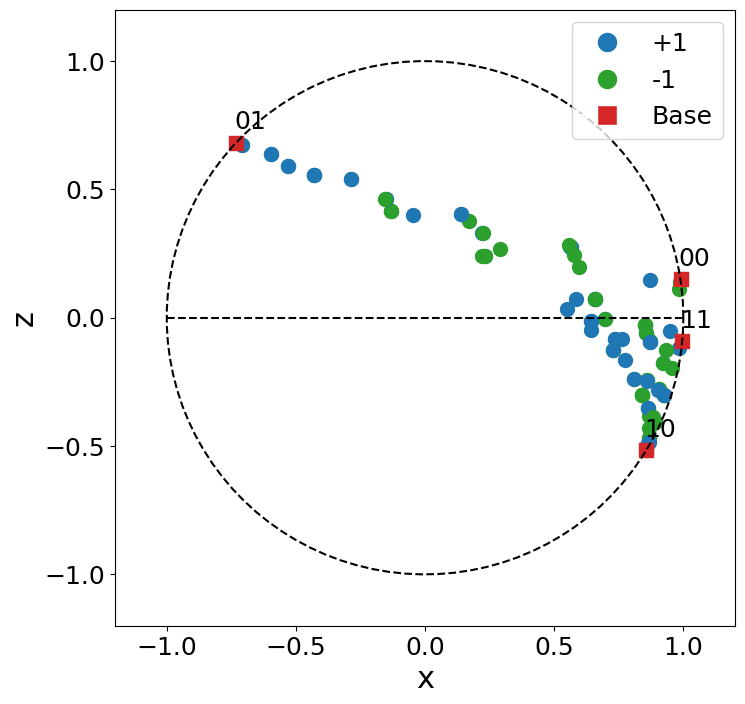

In [25]:
a = np.zeros((len(X), 2))
for i in range(len(X)):
    a[i] = get_bloch_coordinates(x= X[i], theta=theta)
fix_P = [[0, 0], [0, np.pi], [np.pi, 0], [np.pi, np.pi]]
a_base = np.zeros((len(fix_P), 2))
for i in range(len(fix_P)): 
    a_base[i] = get_bloch_coordinates(x= fix_P[i], theta=theta)

plot_bloch_sphere(a,y, a_base)